In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from numba import njit
import vector
import numba as nb
import numpy.ma as ma
vector.register_numba()
vector.register_awkward()


from pprint import pprint 
hep.style.use(hep.style.ROOT)


import hist

In [5]:
df = ak.from_parquet("../dataset_1/all_jets_v6.parquet")

In [6]:
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

jets.type

584143 * var * Momentum4D["pt": float32, "eta": float32, "phi": float32, "btag": float32, "m": float64, "matched": bool, "prov": float64]

In [7]:
def no_zero_awkward(array, feature, jets=True):

    y = array[feature][array[feature] == 0]
    return ak.count(y)

In [8]:
jet_features = ["pt", "eta", "phi", "btag", "m", "matched", "prov"]

print("Jets")
for x in jet_features:
    print(x + ": " + f"{no_zero_awkward(jets, x)}")

print("Leptons")
lept_features = ["pt", "eta", "phi", "m"]

for x in lept_features:
    print(x + ": " + f"{no_zero_awkward(lepton_reco, x, False)}")

print("MET")
lept_features = ["pt", "eta", "phi", "m"]

for x in lept_features:
    print(x + ": " + f"{no_zero_awkward(met, x, False)}")

Jets
pt: 0
eta: 0
phi: 0
btag: 0
m: 3327098
matched: 474407
prov: 0
Leptons
pt: 0
eta: 0
phi: 0
m: 584143
MET
pt: 0
eta: 584143
phi: 0
m: 584143


In [9]:
def to_flat_numpy(X, fields, axis=1, allow_missing=False):
    return np.stack([ak.to_numpy(X[f], allow_missing=allow_missing) for f in fields], axis=axis)

def to_flat_tensor(X, fields, axis=1, allow_missing=False):
    return torch.tensor(np.stack([ak.to_numpy(X[f], allow_missing=allow_missing) for f in fields], axis=axis))



In [10]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [11]:
boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

In [12]:
jets_CM = jets.boost_beta3(-(boost_reco.to_beta3()))
lept_CM = lepton_reco.boost_beta3(-(boost_reco.to_beta3()))
met_CM = met.boost_beta3(-(boost_reco.to_beta3()))

CM_ALL = get_vector_sum(jets_CM) + lept_CM + met_CM

In [13]:
CM_ALL.px

<Array [9.95e-07, 3.9e-06, ... -4.76e-07] type='584143 * float64'>

In [14]:
boost_reco.type

584143 * Momentum4D["x": float64, "y": float64, "z": float64, "t": float64]

In [15]:
print(boost_reco["t"])

rapidity = boost_reco.rapidity
print(rapidity)

rapidy2 = np.log((boost_reco["t"] + boost_reco["z"])/(boost_reco["t"] - boost_reco["z"]))/2
print(rapidy2)

pt = np.sqrt(boost_reco["x"]**2 + boost_reco["y"]**2)
print (pt)

phi = np.arccos(boost_reco["x"]/pt)
print(phi)

m = 0




[707, 2.22e+03, 684, 1.84e+03, 846, ... 1.73e+03, 1.1e+03, 1.05e+03, 882, 1.14e+03]
[1.07, 1.38, -0.745, 0.949, 1.21, 1.21, ... -1.23, -1.13, -0.717, -0.649, -0.00615]
[1.07, 1.38, -0.745, 0.949, 1.21, 1.21, ... -1.23, -1.13, -0.717, -0.649, -0.00615]
[20.7, 6.04, 45.2, 4.77, 91.3, 51.1, 39.8, ... 124, 70, 106, 68.3, 41, 93.9, 27.2]
[0.213, 2.99, 1.93, 2.93, 2.07, 1.5, ... 0.194, 0.462, 0.728, 0.41, 0.259, 0.182]


# PyTorch DNN dataset

In [16]:
import os
import os.path

import numpy as np
import torch
import awkward as ak
from tqdm import tqdm

from torch.utils.data import Dataset

In [17]:
struct_jets = ak.zip({"pt": np.float32(0),
                "eta": np.float32(0),
                "phi": np.float32(0),
                "btag": np.float32(0),
                "m": np.float64(0),
                "matched": bool(0),
                "prov": 0.},
        with_name='Momentum4D')

struct_jets_CM = ak.zip({"x": np.float32(0),
                "y": np.float32(0),
                "z": np.float32(0),
                "tau": np.float32(0),
                "pt": np.float32(0),
                "btag": np.float32(0),
                "m": np.float64(0),
                "matched": bool(0),
                "prov": 0.},
        with_name='Momentum4D')

ones_jets = ak.zip({"pt": np.float32(1),
                "eta": np.float32(1),
                "phi": np.float32(1),
                "btag": np.float32(1),
                "m": np.float64(1),
                "matched": bool(1),
                "prov": 1.},
        with_name='Momentum4D')

struct_lepton = ak.zip({"pt": np.float32(0),
                "eta": np.float32(0),
                "phi": np.float32(0),
                "m": np.float32(0)},
        with_name='Momentum4D')

ones_lepton = ak.zip({"pt": np.float32(1),
                "eta": np.float32(1),
                "phi": np.float32(1),
                "m": np.float32(1)},
        with_name='Momentum4D')

In [18]:
boost = boost_reco

jets_CM = jets.boost_beta3(-(boost.to_beta3()))
lept_CM = lepton_reco.boost_beta3(-(boost.to_beta3()))
met_CM = met.boost_beta3(-(boost.to_beta3()))

print(jets_CM.type)
print(jets.type)

#jets_CM_sum = get_vector_sum(jets_CM)

#final = jets_CM_sum + lept_CM + met

final = get_vector_sum(jets_CM) + lept_CM + met_CM

print(final)

584143 * var * Momentum4D["x": float64, "y": float64, "z": float64, "tau": float64, "pt": float32, "btag": float32, "m": float64, "matched": bool, "prov": float64]
584143 * var * Momentum4D["pt": float32, "eta": float32, "phi": float32, "btag": float32, "m": float64, "matched": bool, "prov": float64]
[{x: 9.95e-07, y: -2.15e-07, z: 2.75e-05, t: 435}, ... z: -1.41e-10, t: 1.14e+03}]


In [19]:
total_px = get_vector_sum(jets_CM)["x"] + lept_CM["x"] + met_CM["x"]
print(total_px)

total_py = get_vector_sum(jets_CM)["y"] + lept_CM["y"] + met_CM["y"]
print(total_py)

[9.95e-07, 3.9e-06, -2.85e-06, 4.62e-08, ... 1.15e-06, 5.15e-06, -4.76e-07]
[-2.15e-07, -1.29e-08, -2.52e-06, 9.72e-09, ... 2.13e-06, 5e-07, 3.54e-07, -9.54e-07]


In [20]:
jets_CM_rapidity = jets_CM.rapidity
jets_CM_rapidity2 = np.log((jets_CM["tau"] + jets_CM["z"])/(jets_CM["tau"] - jets_CM["z"]))/2
if (np.sum(jets_CM_rapidity - jets_CM_rapidity2) > 1E-5):
    print("PROBLEM rapidity" + jets_CM_rapidity)

print(f"Rapidity + {jets_CM_rapidity}")

jets_CM_pt = np.sqrt(jets_CM["x"]**2 + jets_CM["y"]**2)
print(f"pt + {jets_CM_pt}")
print(f"jet_pt:")
print(jets_CM["pt"])

jets_CM_phi = np.arccos(jets_CM["x"]/jets_CM_pt)
print(f"phi + {jets_CM_phi}")


jets_copy = jets
jets_copy["pt"] = jets_CM_pt
jets_copy["eta"] = jets_CM_rapidity
jets_copy["phi"] = jets_CM_phi
jets_copy["btag"] = jets_copy["btag"]
jets_copy["m"] = jets_copy["m"]
jets_copy["matched"] = jets_copy["matched"]
jets_copy["prov"] = jets_copy["prov"]


print("COPY:")

print(jets_copy["pt"][0])
print(jets_copy["eta"][0])
print(jets_copy["phi"][0])

print(jets_copy.type)

print(lepton_reco.type)
print(lept_CM.type)

lept_CM_pt = np.sqrt(lept_CM["x"]**2 + lept_CM["y"]**2)
met_CM_pt = np.sqrt(met_CM["x"]**2 + met_CM["y"]**2)

/Users/antoniopetre/anaconda3/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(


Rapidity + [[-0.224, 0.441, 0.392, -1.04, 1.36], ... [0.226, -1.7, 1.66, -0.78, 0.278]]
pt + [[70.7, 54.6, 39.7, 29.7, 27.2], [142, 125, ... 38.5], [136, 130, 113, 63.7, 37]]
jet_pt:
[[68.3, 58, 40.4, 30.7, 30.4], [142, 126, ... 33.6], [134, 128, 119, 65.3, 36.2]]
phi + [[2.28, 0.438, 1.51, 0.571, 0.404], [1.18, ... [2.32, 1.61, 0.788, 0.448, 2.89]]
COPY:
[70.7, 54.6, 39.7, 29.7, 27.2]
[-0.224, 0.441, 0.392, -1.04, 1.36]
[2.28, 0.438, 1.51, 0.571, 0.404]
584143 * var * Momentum4D["pt": float64, "eta": float64, "phi": float64, "btag": float32, "m": float64, "matched": bool, "prov": float64]
584143 * Momentum4D["pt": float32, "eta": float32, "phi": float32, "m": float64]
584143 * Momentum4D["x": float64, "y": float64, "z": float64, "tau": float64, "pt": float32, "m": float64]


In [39]:
class MyDataset(Dataset):
    def __init__(self, root, object_types=["jets", "lepton_reco", "met", "boost"], transform=None):
        
        self.root = root
        self.transform = transform
        self.object_types = object_types
        
        for object_type in self.object_types:
            if not os.path.isfile(self.processed_file_names(object_type)):
                print("Create new file for " + object_type)
                self.process(object_type)
            else:
                print(object_type + " file already exists")
        
    
        self.mask_jets, self.data_jets = torch.load(self.processed_file_names("jets"))
        self.mask_lepton, self.data_lepton = torch.load(self.processed_file_names("lepton_reco"))
        self.mask_met, self.data_met = torch.load(self.processed_file_names("met"))
        self.mask_boost, self.data_boost = torch.load(self.processed_file_names("boost"))
        
    @property
    def raw_file_names(self):
        return [self.root + '/all_jets_v6.parquet']

    def processed_file_names(self, type):

        return (self.root + '/processed/' + type + '_data.pt')
    
    def fields(self, type):
        if type == "jets":
            return ["pt", "eta", "phi", "btag", "m", "matched", "prov"]
        
        elif type == "lepton_reco":
            return ["pt", "eta", "phi", "m"]
        
        elif type == "met":
            return ["pt", "eta", "phi", "m"]
        
        elif type == "boost":
            return ["x", "y", "z", "t"]
        
    def boost_CM(self, objects_array, boost, object_type):
        objects_CM = objects_array.boost_beta3(-(boost_reco.to_beta3()))

        mask_py = ak.mask(objects_CM, objects_CM["y"] > 0)

        objects_CM_rapidity = objects_CM.rapidity
        #objects_CM_rapidity2 = np.log((objects_CM["tau"] + objects_CM["z"])/(objects_CM["tau"] - objects_CM["z"]))/2
        #if (np.sum(objects_CM_rapidity - objects_CM_rapidity2) > 1E-5):
        #    print("PROBLEM rapidity" + objects_CM_rapidity)

        objects_CM_pt = np.sqrt(objects_CM["x"]*objects_CM["x"] + objects_CM["y"]*objects_CM["y"])

        objects_CM_phi = np.arccos(objects_CM["x"]/objects_CM_pt)

        objects_copy = objects_array
        objects_copy["pt"] = objects_CM_pt
        objects_copy["eta"] = objects_CM_rapidity
        objects_copy["phi"] = objects_CM_phi

        
        print(mask_py.type)
        #print(objects_copy[0]["phi"])
        print(mask_py[0]["y"])
        #print(objects_copy["phi"].type)
        objects_copy["phi"] += mask_py["y"]*0 - 7

        if object_type == "jets":
            objects_copy["btag"] = objects_array["btag"]
            objects_copy["m"] = objects_array["m"]
            objects_copy["matched"] = objects_array["matched"]
            objects_copy["prov"] = objects_array["prov"]
        else:
            objects_copy["m"] = objects_array["m"]

        #print(objects_copy.type)

        return mask_py, objects_copy

        
    def Reshape(self, input, value, ax):
        max_no = ak.max(ak.num(input, axis=ax))
        input_padded =  ak.pad_none(input, max_no, axis=ax)
        input_filled = ak.fill_none(input_padded, value, axis=ax)
    
        return input_filled
        
    def add_boost(self, boost):

        boost_list = to_flat_numpy(boost, self.fields("boost"), axis=1, allow_missing=False)
        return boost_list
    
    # Get mask for object with pt = 0
    def get_mask_pt(self, objects_array):
        a = ma.masked_equal(objects_array, 0)
        mask = ma.getmaskarray(a)
        return mask[:, :, 0]

    def process(self, object_type):
                
        for file in self.raw_file_names:
            df = ak.from_parquet(file)
            
            if (object_type == "boost"):
                objects = boost_reco                

            else:
                objects = ak.with_name(df[object_type], name="Momentum4D")
                mask_py, objects = self.boost_CM(objects, boost_reco, object_type)

            #print(mask_py.type)
            #print(mask_py)



            if object_type == "jets":
                objects = self.Reshape(objects, struct_jets, 1)
                
            d_list = to_flat_numpy(objects, self.fields(object_type), axis=1, allow_missing=False)

            if object_type == "jets":
                d_list = np.transpose(d_list, (0, 2, 1))

            if (object_type == "lepton_reco" or object_type == "met" or object_type == "boost"):
                d_list = np.expand_dims(d_list, axis=1)
                    
            mask = self.get_mask_pt(d_list)

            #d_list[mask_phi] = 2*3.141359 - d_list[mask_phi]
            #print(f"Data_shape: {object_type} " + f"{d_list.shape}")
            #print("Mask_shape: " + f"{mask.shape}")

            tensor_data = torch.tensor(d_list, dtype = torch.float)
            tensor_mask = torch.tensor(mask, dtype = torch.float)
            print("")

            torch.save((tensor_mask, tensor_data), self.processed_file_names(object_type))
                    
    def __getitem__(self, index):

        return self.mask_lepton[index], self.data_lepton[index], self.mask_jets[index], self.data_jets[index], self.mask_met[index], self.data_met[index], self.mask_boost[index], self.data_boost[index]
            
    def __len__(self):
        return len(self.data)
    
    # change coordinate of boost - not used
    def change_coord(self, boost):

        np.set_printoptions(precision=7)


        rapidity = boost_reco.rapidity
        rapidity2 = np.log((boost_reco["t"] + boost_reco["z"])/(boost_reco["t"] - boost_reco["z"]))/2
        if (np.sum(rapidity - rapidity2) > 1E-5):
            print("PROBLEM rapidity" + rapidity2)

        pt = np.sqrt(boost_reco["x"]**2 + boost_reco["y"]**2)
        phi = np.emath.arccos(boost_reco["x"]/pt)
        rapidity2 = np.expand_dims(rapidity2, axis=1)

        pt = np.expand_dims(pt, axis=1)
        phi = np.expand_dims(phi, axis=1)
        m = np.zeros((584143, 1))

        rapidity2 = np.array(rapidity2)
        pt = np.array(pt)
        phi = np.array(phi)
        
        boost_array = np.concatenate((pt, rapidity2, phi, m), axis=1)
        boost_array = np.expand_dims(boost_array, axis=1)

        return boost_array

In [40]:
data = MyDataset(".")

Create new file for jets
584143 * var * ?Momentum4D["x": float64, "y": float64, "z": float64, "tau": float64, "pt": float32, "btag": float32, "m": float64, "matched": bool, "prov": float64]
[53.5, None, None, 16.1, 10.7]


TypeError: operand type(s) all returned NotImplemented from __array_ufunc__(<ufunc 'add'>, '__call__', <Array [[2.28, 0.438, 1.51, ... 0.448, 2.89]] type='584143 * var * float64'>, <Array [[-7, None, None, -7, ... -7, None, -7]] type='584143 * var * ?float64'>, out=(<Array [[2.28, 0.438, 1.51, ... 0.448, 2.89]] type='584143 * var * float64'>,)): 'Array', 'Array', 'Array'

In [134]:
x = data.data_jets[:,:,1] > 0

print(x.shape)
print(x)

print(data.data_jets)

torch.Size([584143, 15])
tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])


In [130]:
jets_px = np.cos(data.data_jets[:,:,2])*data.data_jets[:,:,0]
jets_py = np.sin(data.data_jets[:,:,2])*data.data_jets[:,:,0]

lept_px = np.cos(data.data_lepton[:,:,2])*data.data_lepton[:,:,0]
lept_py = np.sin(data.data_lepton[:,:,2])*data.data_lepton[:,:,0]

met_px = np.cos(data.data_met[:,:,2])*data.data_met[:,:,0]
met_py = np.sin(data.data_met[:,:,2])*data.data_met[:,:,0]

print(jets_px.shape)
print(lept_px.shape)

torch.Size([584143, 15])
torch.Size([584143, 1])


In [131]:
jets_px_sum = torch.sum(jets_px, dim=1)
jets_px_sum = torch.unsqueeze(jets_px_sum, 1)
print(jets_px_sum.shape)

jets_py_sum = torch.sum(jets_py, dim=1)
jets_py_sum = torch.unsqueeze(jets_py_sum, 1)
print(jets_py_sum.shape)

total_px = torch.cat((jets_px_sum, lept_px, met_px), dim=1)
total_py = torch.cat((jets_py_sum, lept_py, met_py), dim=1)

sum_px_event = torch.sum(total_px, dim=1)
sum_py_event = torch.sum(total_py, dim=1)

print(sum_px_event)
print(sum_py_event)

print(torch.sum(sum_py_event))
print(torch.sum(sum_px_event))

torch.Size([584143, 1])
torch.Size([584143, 1])
tensor([  65.9630,  102.2432, -241.2972,  ..., -182.0020,   19.6934,
        -100.2424])
tensor([219.6747, 529.6730, 318.7186,  ..., 590.9967, 408.3125, 505.4665])
tensor(2.4950e+08)
tensor(-988457.)


In [101]:
print(data.data_jets[0, :, 0])
print(data.mask_jets[0])

tensor([70.7013, 54.6426, 39.7297, 29.7051, 27.1881,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [95]:
print(data.mask_jets.shape)
print(data.mask_lepton.shape)
print(data.mask_met.shape)
print(data.mask_boost.shape)

torch.Size([584143, 15])
torch.Size([584143, 1])
torch.Size([584143, 1])
torch.Size([584143, 1])


In [96]:
from torch.utils.data import DataLoader

data_loaded = DataLoader(data, batch_size=64, drop_last=True)

lepton_batch, jets_batch, met_batch = next(iter(data_loaded))

#mask_jets_training = DataLoader(mask_jets, batch_size=64, shuffle=False, drop_last=True)
#mask_lepton_training = DataLoader(mask_lepton, batch_size=64, shuffle=False, drop_last=True)
#mask_met_training = DataLoader(mask_met, batch_size=64, shuffle=False, drop_last=True)

AttributeError: 'MyDataset' object has no attribute 'data'

In [258]:
jet_firstbatch = next(iter(jets_training))
lepton_firstbatch = next(iter(lepton_training))
met_firstbatch = next(iter(met_training))

mask_jet_firstbatch = next(iter(mask_jets_training))
mask_lepton_firstbatch = next(iter(mask_lepton_training))
mask_met_firstbatch = next(iter(mask_met_training))


In [269]:
jet_firstbatch.shape

torch.Size([64, 15, 7])

In [270]:
mask_jet  = jet_firstbatch[:,:,0] > 0
mask_jet.shape

torch.Size([64, 15])

In [259]:
import torch
import torch.nn as nn

lin_jet = nn.Linear(in_features=7, 
         out_features=64)

act_jet = nn.GELU()

lin_lept = nn.Linear(in_features=4, 
         out_features=64)

act_lept = nn.GELU()

## TO DO ADD 1 for jets, 2 for lept and 3 for met
## TO DO SHuffle 
## TO DO add everything there: jets/lepton_reco and met in the same DataSet

## Compute boost ( e in genlevelplots)

## Also the 4 vectors are boosted

In [274]:
#lin_jet.weight.data.mul_(mask_jet_firstbatch)
print(lin_jet.weight.data.shape)
#print(mask_jet_firstbatch.shape)

jet_transformed = lin_jet(jet_firstbatch)*mask_jet[:,:,None]
lept_transformed = lin_lept(lepton_firstbatch)
met_transformed = lin_lept(met_firstbatch)

print(jet_transformed.shape)
print(lept_transformed.shape)
print(met_transformed.shape)

torch.Size([64, 7])
torch.Size([64, 15, 64])
torch.Size([64, 1, 64])
torch.Size([64, 1, 64])


In [244]:
import matplotlib.pyplot as plt

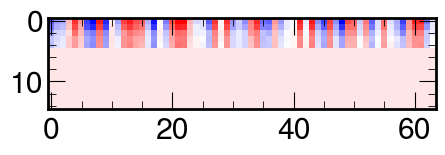

In [282]:
plt.figure(figsize=(5,3), dpi=100)
plt.imshow(jet_transformed[0].detach().numpy(), cmap="bwr")

In [238]:
avgpool_2d = nn.AvgPool2d(kernel_size=[15,1], stride=[1,1], count_include_pad=True)

jet_avg = avgpool_2d(jet_transformed)

print(jet_avg[0])

print(jet_avg.shape)

jet_lepton_transformed = torch.cat((jet_avg, lept_transformed), dim=1)
all_transformed = torch.cat((jet_lepton_transformed, met_transformed), dim=1)

print(all_transformed.shape)

tensor([[-5.1810, -0.5245, -5.0003, -1.7494, -1.3954, -2.8781, -3.6989, -0.9320,
         -3.3120,  4.3984, -4.2116, -5.7280, -5.0684,  0.7678, -0.3487,  4.0019,
          4.0706,  3.8682, -1.5998, -0.9973, -0.6904,  5.4758,  4.9154,  0.6586,
         -0.5711, -0.6491,  3.2157,  0.4260,  2.7971, -2.5998,  2.3884,  3.6848,
         -3.5473, -5.5061, -0.0877, -3.6483, -5.0697, -2.3119, -2.3935,  0.3546,
         -1.1535, -2.1671,  4.4594,  5.1459, -0.6749, -3.1376,  1.5460, -4.9337,
         -0.1551,  2.7311,  0.3935, -4.3653,  5.7904,  4.9355, -0.8735,  4.1431,
         -0.3310,  5.0975, -4.5068, -4.1587, -2.5411,  2.1758,  5.6519,  1.4546]],
       grad_fn=<SelectBackward0>)
torch.Size([64, 1, 64])
torch.Size([64, 3, 64])


In [284]:
## TRANSFORMER LAYER

encoder_layer = nn.TransformerEncoderLayer(d_model=64,
                                           nhead=8,
                                          batch_first=True)

transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
out = encoder_layer(jet_transformed + lept_features + .. + MASK)

print(out.shape)

# average on all the space including lepton and met

torch.Size([64, 15, 64])


In [228]:
print(out.shape)

torch.Size([64, 3, 64])


In [229]:
""""
mask_jets = ak.fill_none(mask_jets, ones_jets, axis=1) 
mask_lepton = ak.fill_none(mask_lepton, ones_lepton)
mask_met = ak.fill_none(mask_met, ones_lepton)

jet_features = ["pt", "eta", "phi", "btag", "m", "matched", "prov"]
lept_features = ["pt", "eta", "phi", "m"]

mask_jets_numpy = to_flat_numpy(mask_jets, jet_features, axis=1, allow_missing=False)
mask_jets_tensor = torch.tensor(mask_jets_numpy, dtype = torch.float)

mask_lept_numpy = to_flat_numpy(mask_lepton, lept_features, axis=1, allow_missing=False)
mask_lept_tensor = torch.tensor(mask_lept_numpy, dtype = torch.float)

mask_met_numpy = to_flat_numpy(mask_met, lept_features, axis=1, allow_missing=False)
mask_met_tensor = torch.tensor(mask_met_numpy, dtype = torch.float)

print(mask_jets_tensor.shape)
print(mask_lept_tensor.shape)
print(mask_met_tensor.shape)
"""

'"\nmask_jets = ak.fill_none(mask_jets, ones_jets, axis=1) \nmask_lepton = ak.fill_none(mask_lepton, ones_lepton)\nmask_met = ak.fill_none(mask_met, ones_lepton)\n\njet_features = ["pt", "eta", "phi", "btag", "m", "matched", "prov"]\nlept_features = ["pt", "eta", "phi", "m"]\n\nmask_jets_numpy = to_flat_numpy(mask_jets, jet_features, axis=1, allow_missing=False)\nmask_jets_tensor = torch.tensor(mask_jets_numpy, dtype = torch.float)\n\nmask_lept_numpy = to_flat_numpy(mask_lepton, lept_features, axis=1, allow_missing=False)\nmask_lept_tensor = torch.tensor(mask_lept_numpy, dtype = torch.float)\n\nmask_met_numpy = to_flat_numpy(mask_met, lept_features, axis=1, allow_missing=False)\nmask_met_tensor = torch.tensor(mask_met_numpy, dtype = torch.float)\n\nprint(mask_jets_tensor.shape)\nprint(mask_lept_tensor.shape)\nprint(mask_met_tensor.shape)\n'

In [ ]:
x = zip(jets_training, lepton_training)


for idx, x in enumerate(x):
    print(idx)

In [ ]:
import torch
import torch.nn as nn

lin_jet = nn.Linear(in_features=7, 
         out_features=64)
act_jet = nn.GELU()

lin_lept = nn.Linear(in_features=4, 
         out_features=64)
act_lept = nn.GELU()

encoder_layer = nn.TransformerEncoderLayer(d_model=64,
                                           nhead=8,
                                          batch_first=True)

transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

jets_training = DataLoader(jets_data, batch_size=64, shuffle=False, drop_last=True)
lepton_training = DataLoader(lepton_data, batch_size=64, shuffle=False, drop_last=True)
met_training = DataLoader(met_data, batch_size=64, shuffle=False, drop_last=True)

full_training = zip(jets_training, lepton_training, met_training)

#for idx, x in enumerate(full_training):
#    jet_transformed = lin_jet(x[0])
#    lept_transformed = lin_lept(x[1])
#    met_transformed = lin_lept(x[2])
#    
#    jet_lepton_transformed = torch.cat((jet_transformed, lept_transformed), dim=1)
#    all_transformed = torch.cat((jet_lepton_transformed, met_transformed), dim=1)
    
#    batch_encoded = transformer_encoder(all_transformed)
#    print(idx)


In [ ]:
import torch
from torch.nn import Linear, Parameter


class Transformer():
    def __init__(self, in_channels, out_channels, nhead, no_layers):
        super().__init__()
        
        self.in_channels = in_channels
        
        for i in self.in_channels:
            self.lin = nn.ModuleList(Linear(i, out_channels))
            
        
        self.nhead = nhead
        self.no_layers = no_layers
        self.reset_parameters()

    def reset_parameters(self):
        for lin in self.lin:
            lin.reset_parameters()

    def forward(self, x):
        # x contains "events" with shape [batch, no_objects, no_features]
        
        self.gelu = nn.GELU()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.out_channels,
                                           nhead=self.nhead,
                                          batch_first=True)

        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.no_layers)
        
        for batches in x:
            for j in range(len(self.in_channels)):
                batch_transformed[j] = self.lin[j](batches[j])
                if j == 0:
                    all_batch = batch_transformed[j]
                if j > 0:
                    all_batch = torch.cat((all_batch, batch_transformed[j]), dim=1)
                
            batch_encoded = transformer_encoder(all_batch)
            output = torch.cat((output, batch_encoded), dim=0)
        
        return out

    def message(self, x_i, x_j, norm):
        # x_j has shape [E, out_channels]
        print(x_i[0:10])
        print(x_j[0:10])
        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_i

In [ ]:
#TO DO CONVOLUTION

import torch
import torch.nn as nn

jet_conv = nn.Conv1d(in_channels=15, out_channels=15, kernel_size=7, stride=1)

jet_output = torch.randn(1, 15, 1)
zero = torch.ones(584129, 15, 1) #type = jet (1 last digit)

ok = 0

#for local_batch in jets_training:
y = jet_conv(jet_firstbatch)
    #print(x.shape)
#jet_output = torch.cat((jet_output, x), 0)

#print(jet_output.shape)
#jet_output = torch.cat((jet_output, zero), dim=-1)

In [ ]:
act(lin(x)).shape

In [ ]:
print(y.shape)

In [ ]:
import torch
import torch.nn as nn

lepton_conv = nn.Conv1d(4, 1, 1)

lepton_output = torch.randn(1, 1, 1)
met_output = torch.randn(1, 1, 1)

one = 2*torch.ones(584129, 1, 1) # type leptons = 2
two = 3*torch.ones(584129, 1, 1) #type met = 3


for local_batch in lepton_training:
    x = lepton_conv(local_batch)
    #print(x.shape)
    lepton_output = torch.cat((lepton_output, x), 0)
    #print(x.shape)

for local_batch in met_training:
    x = lepton_conv(local_batch)
    met_output = torch.cat((met_output, x), 0)
    #print(x.shape)


lepton_output = torch.cat((lepton_output, one), dim=-1)
met_output = torch.cat((met_output, two), dim=-1)

print(lepton_output.shape)

In [ ]:
torch.save(jet_output, './trained_data/jet_output.pt')

In [ ]:
torch.save(lepton_output, './trained_data/lepton_output.pt')
torch.save(met_output, './trained_data/met_output.pt')

In [ ]:
jet = torch.load('./trained_data/jet_output.pt')
lepton = torch.load('./trained_data/lepton_output.pt')
met = torch.load('./trained_data/met_output.pt')

In [ ]:
jet = jet[1:,:,:]
lepton = lepton[1:,:,:]
met = met[1:,:,:]

In [ ]:
jet_lepton = torch.cat((jet, lepton), dim=1)
all_ = torch.cat((jet_lepton, met), dim=1)

In [ ]:
all_.shape

In [ ]:
all_

In [ ]:
load_data = DataLoader(all_, batch_size=64, shuffle=False, drop_last=True)

## NOW Suppose all_ is input of MultiHead Attention

In [ ]:
import torch
import torch.nn as nn

embed_dim = 256
num_heads = 64

multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
attn_output, attn_output_weights = multihead_attn(query, key, value)

In [ ]:
x = zip(jets_training, lepton_training, met_training)

for i in x:
    for j in range(len(in_channels))